In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os 
import math
from scipy.fft import fft2, fftshift, ifftshift, ifft2
import nibabel as nib

import torch
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
#from pytorch_msssim import SSIM

In [2]:
# Ouvrir DCM
'''import pydicom
import matplotlib.pyplot as plt

# Charger le fichier DICOM
dcm = pydicom.dcmread("fastmri_prostate_DICOMS_IDS_001_312/DICOMS/001/AX_DIFFUSION_CALC_BVAL/368.dcm")

# Afficher les métadonnées
print(dcm)

# Afficher l'image si elle existe
if 'PixelData' in dcm:
    plt.imshow(dcm.pixel_array, cmap="gray")
    plt.title("Image DICOM")
    plt.axis("off")
    plt.show()
else:
    print("Pas de données d'image dans ce fichier.")'''


'import pydicom\nimport matplotlib.pyplot as plt\n\n# Charger le fichier DICOM\ndcm = pydicom.dcmread("fastmri_prostate_DICOMS_IDS_001_312/DICOMS/001/AX_DIFFUSION_CALC_BVAL/368.dcm")\n\n# Afficher les métadonnées\nprint(dcm)\n\n# Afficher l\'image si elle existe\nif \'PixelData\' in dcm:\n    plt.imshow(dcm.pixel_array, cmap="gray")\n    plt.title("Image DICOM")\n    plt.axis("off")\n    plt.show()\nelse:\n    print("Pas de données d\'image dans ce fichier.")'

In [3]:
# import os
# from PIL import Image
# import imagehash

# def supprimer_images_similaires(dossier, seuil=5):
#     """
#     Supprime les images visuellement similaires dans un dossier,
#     même si elles ont des tailles ou formats différents.
    
#     seuil = distance max entre deux images pour les considérer comme "identiques"
#     (plus il est bas, plus la détection est stricte)
#     """
#     hash_dict = {}
#     fichiers = os.listdir(dossier)
#     fichiers.sort()

#     for nom_fichier in fichiers:
#         chemin = os.path.join(dossier, nom_fichier)
#         if not os.path.isfile(chemin):
#             continue
#         try:
#             with Image.open(chemin) as img:
#                 img = img.convert('RGB')
#                 img = img.resize((128, 128))  # Redimension commune
#                 hash_img = imagehash.phash(img)

#                 # Comparaison avec les hashs déjà vus
#                 doublon_trouvé = False
#                 for hash_existant in hash_dict:
#                     distance = hash_img - hash_existant
#                     if distance <= seuil:
#                         print(f"Suppression de {nom_fichier} (similaire à {hash_dict[hash_existant]}) [distance={distance}]")
#                         os.remove(chemin)
#                         doublon_trouvé = True
#                         break

#                 if not doublon_trouvé:
#                     hash_dict[hash_img] = nom_fichier

#         except Exception as e:
#             print(f"Erreur avec {nom_fichier} : {e}")

# supprimer_images_similaires("archive/Training/Foncee", seuil=5)

 

In [4]:
#LOAD DES IMAGES NII

'''import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from scipy.ndimage import zoom

# Dossier contenant les images
folder_tr = "D:/ForRaphael/ForRaphael/pelvis"

# Lister tous les fichiers .nii.gz dans les sous-dossiers
files_with_paths = []
for root, dirs, files in os.walk(folder_tr):
    for f in files:
        if f.endswith('mr.nii.gz'):
            files_with_paths.append(os.path.join(root, f))

# Trier la liste complète et prendre les 5 premiers
files_with_paths = sorted(files_with_paths)#[:5]

# Charger et stocker les données
images_normalized = []

target_shape = (64, 64)  # forme finale souhaitée

for path in files_with_paths:
    img = nib.load(path)
    data = img.get_fdata()

    slice = data[:, :, 60]  # Extraire la coupe

    # Sous-échantillonnage simple
    slice_resized = slice[::2, ::2]

    # Calcul du facteur d'interpolation pour avoir toujours la même taille
    zoom_factors = (target_shape[0] / slice_resized.shape[0],
                    target_shape[1] / slice_resized.shape[1])
    slice_fixed = zoom(slice_resized, zoom=zoom_factors)

    # Normalisation
    slice_normalized = np.float32(slice_fixed - np.min(slice_fixed)) / (np.max(slice_fixed) - np.min(slice_fixed))

    # Ajouter l'image normalisée (transposée pour affichage correct)
    images_normalized.append(slice_normalized.T)

# Conversion en tableau numpy
bigy = np.array(images_normalized)
np.save("images_pelvis_64.npy", bigy)
print("Répertoire courant :", os.getcwd())
print(bigy.shape)

# Affichage d’une image
plt.imshow(bigy[4,:,:], cmap="gray", origin="lower")
plt.show()
'''



'import os\nimport numpy as np\nimport nibabel as nib\nimport matplotlib.pyplot as plt\n\nfrom scipy.ndimage import zoom\n\n# Dossier contenant les images\nfolder_tr = "D:/ForRaphael/ForRaphael/pelvis"\n\n# Lister tous les fichiers .nii.gz dans les sous-dossiers\nfiles_with_paths = []\nfor root, dirs, files in os.walk(folder_tr):\n    for f in files:\n        if f.endswith(\'mr.nii.gz\'):\n            files_with_paths.append(os.path.join(root, f))\n\n# Trier la liste complète et prendre les 5 premiers\nfiles_with_paths = sorted(files_with_paths)#[:5]\n\n# Charger et stocker les données\nimages_normalized = []\n\ntarget_shape = (64, 64)  # forme finale souhaitée\n\nfor path in files_with_paths:\n    img = nib.load(path)\n    data = img.get_fdata()\n\n    slice = data[:, :, 60]  # Extraire la coupe\n\n    # Sous-échantillonnage simple\n    slice_resized = slice[::2, ::2]\n\n    # Calcul du facteur d\'interpolation pour avoir toujours la même taille\n    zoom_factors = (target_shape[0] / 

In [5]:
'''#Importer Image Jpeg
path_folder = os.getcwd()
import os
import numpy as np
from PIL import Image

folder='c:/Users/rapha/OneDrive/Bureau/Stage_Ing4/archive/Training/Clair_propre'

image_files = sorted([f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    
images_normalized = []
for fname in image_files:
    img = Image.open(os.path.join(folder, fname)).convert('L')  # grayscale
    img = img.resize((64, 64))  # resize to match original shape
    slice_normalized =np.float32(img- np.min(img)) / (np.max(img) - np.min(img))
    #img = np.array(slice_normalized)
    images_normalized.append(slice_normalized)

bigy = np.stack(images_normalized) #Empiler un tableau nunpy
#bigy  = bigy  * 2 / 1 - 1
print(bigy.shape)
print(f"Plage des valeurs des images d'entrée (bruitées) : {bigy.min()} - {bigy.max()}")
np.save('data/Test_x_real.npy', bigy)

image_propre=np.array(bigy)
print(image_propre.shape)
print(f"Plage des valeurs des images d'entrée (bruitées) : {image_propre.min()} - {image_propre.max()}")
#plt.imshow(bigy[4,:,:], cmap="gray", origin="lower")'''

'#Importer Image Jpeg\npath_folder = os.getcwd()\nimport os\nimport numpy as np\nfrom PIL import Image\n\nfolder=\'c:/Users/rapha/OneDrive/Bureau/Stage_Ing4/archive/Training/Clair_propre\'\n\nimage_files = sorted([f for f in os.listdir(folder) if f.lower().endswith((\'.jpg\', \'.jpeg\', \'.png\'))])\n    \nimages_normalized = []\nfor fname in image_files:\n    img = Image.open(os.path.join(folder, fname)).convert(\'L\')  # grayscale\n    img = img.resize((64, 64))  # resize to match original shape\n    slice_normalized =np.float32(img- np.min(img)) / (np.max(img) - np.min(img))\n    #img = np.array(slice_normalized)\n    images_normalized.append(slice_normalized)\n\nbigy = np.stack(images_normalized) #Empiler un tableau nunpy\n#bigy  = bigy  * 2 / 1 - 1\nprint(bigy.shape)\nprint(f"Plage des valeurs des images d\'entrée (bruitées) : {bigy.min()} - {bigy.max()}")\nnp.save(\'data/Test_x_real.npy\', bigy)\n\nimage_propre=np.array(bigy)\nprint(image_propre.shape)\nprint(f"Plage des valeurs 

(10, 64, 64)
Mean: 0.20212580040809575
le min et le max 0.0 -1.000000020084274
[0.06785464 0.06785543 0.06786672 0.06795552 0.06805351 0.07574987
 0.07610091 0.08480796 0.11250543 0.80769424 0.55225746 0.48662521
 0.28412349 0.38984963 0.42388263 0.48014046 0.52607568 0.57807858
 0.58196379 0.54311171 0.55534373 0.58143302 0.58333728 0.57755213
 0.58641824 0.59096369 0.6022799  0.61512898 0.61690047 0.60024792
 0.53692747 0.61080621 0.50286702 0.59241285 0.60263193 0.6328315
 0.37446531 0.58507543 0.60681474 0.60852388 0.60737394 0.60696927
 0.61883185 0.58048773 0.50275194 0.56277765 0.55595053 0.40199982
 0.29618679 0.41037218 0.40503746 0.57020401 0.39378658 0.80429917
 0.07232216 0.0829695  0.07617757 0.07493816 0.0708921  0.06782852
 0.06784134 0.06785305 0.06785454 0.06785464]


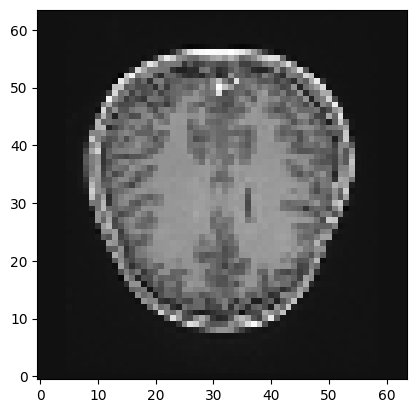

In [3]:
path_folder = os.getcwd()
import os
import numpy as np
from PIL import Image
indices_base =[71, 94, 84, 116, 61, 31, 52, 16, 35, 95] # (Masque différent)
data_base = np.load("images_brain_64.npy")#[11:21]
bigy=data_base[indices_base]

print(bigy.shape)
print("Mean:", bigy.mean().item())
print(f"le min et le max {bigy.min()} -{bigy.max()}")
print(bigy[4,32,:],)
# Affichage d’une image
plt.imshow(bigy[4,:,:], cmap="gray", origin="lower")
plt.show()


In [4]:
data_base0 = np.load("images_brain_64.npy")
bigy0=data_base0
#bigy=data_base[indices_base]

print(bigy0.shape)
print("Mean:", bigy0.mean().item())
print(f"le min et le max {bigy0.min()} -{bigy0.max()}")

(180, 64, 64)
Mean: 0.17564063248721856
le min et le max 0.0 -1.0000000542488139


In [8]:
# n_images=180
# cols = 10  # tu peux ajuster
# rows = math.ceil(n_images / cols)

# # Taille de la figure (ajuster selon ton écran)
# fig, axs = plt.subplots(rows, cols, figsize=(cols * 1.5, rows * 1.5))

# # Affichage de chaque image
# for i in range(rows * cols):
#     if i < n_images:
#         axs[i // cols, i % cols].imshow(bigy[i,:,:], cmap='gray', origin='lower')
#     axs[i // cols, i % cols].axis('off')

# plt.tight_layout()
# plt.show()

In [9]:
#TESTER LES ROTATIONS

'''from scipy.ndimage import rotate

# Rotation image réel
image_original=images_normalized[0]
image_rotate=rotate(images_normalized[0], angle=180, reshape=True)
#F_mirror0 = np.fliplr(images_normalized[0])
F_mirror0 = np.flipud(images_normalized[0])

# Rotation image fréquentie
FT1 = fft2(images_normalized[0])


F_shifted_1 = fftshift(FT1)

F_shifted_2 = fftshift(FT1)
F_shifted_2_rotate=rotate(F_shifted_2, angle=180, reshape=True)

F_shifted_3 = fftshift(FT1)
#F_mirror = np.fliplr(F_shifted_3)
F_mirror = np.flipud(F_shifted_3)

image_filtered_1 = np.abs(F_shifted_1)
image_filtered_2 = np.abs(F_shifted_2_rotate)
image_filtered_3 = np.abs(F_mirror)

# Rotation image fréquentiel -> réel

transforme1=ifft2(ifftshift(F_shifted_1)) 
transforme2=ifft2(ifftshift(F_shifted_2_rotate))
transforme3=ifft2(ifftshift(F_mirror)) 

image_filtered_4 = np.abs(transforme1)
image_filtered_5 = np.abs(transforme2)
image_filtered_6 = np.abs(transforme3)


plt.figure(figsize=(10, 8))
plt.subplot(3, 3, 1)
plt.imshow(image_original, cmap='gray')
plt.title("Image originale")
plt.axis('off')

plt.subplot(3, 3, 2)
plt.imshow(image_rotate, cmap='gray')
plt.title("Image tournée 180°")
plt.axis('off')

plt.subplot(3, 3, 3)
plt.imshow(F_mirror0, cmap='gray')
plt.title("Image originale")
plt.axis('off')

plt.subplot(3, 3, 4)
plt.imshow(image_filtered_1, cmap='gray')
plt.title("Image originale")
plt.axis('off')

plt.subplot(3, 3, 5)
plt.imshow(image_filtered_2, cmap='gray')
plt.title("Image tournée 180°")
plt.axis('off')

plt.subplot(3, 3, 6)
plt.imshow(image_filtered_3, cmap='gray')
plt.title("Image tournée 180°")
plt.axis('off')

plt.subplot(3, 3, 7)
plt.imshow(image_filtered_4, cmap='gray')
plt.title("Image originale")
plt.axis('off')

plt.subplot(3, 3, 8)
plt.imshow(image_filtered_5, cmap='gray')
plt.title("Image tournée 180°")
plt.axis('off')

plt.subplot(3, 3, 9)
plt.imshow(image_filtered_6, cmap='gray')
plt.title("Image tournée 180°")
plt.axis('off')
'''


'from scipy.ndimage import rotate\n\n# Rotation image réel\nimage_original=images_normalized[0]\nimage_rotate=rotate(images_normalized[0], angle=180, reshape=True)\n#F_mirror0 = np.fliplr(images_normalized[0])\nF_mirror0 = np.flipud(images_normalized[0])\n\n# Rotation image fréquentie\nFT1 = fft2(images_normalized[0])\n\n\nF_shifted_1 = fftshift(FT1)\n\nF_shifted_2 = fftshift(FT1)\nF_shifted_2_rotate=rotate(F_shifted_2, angle=180, reshape=True)\n\nF_shifted_3 = fftshift(FT1)\n#F_mirror = np.fliplr(F_shifted_3)\nF_mirror = np.flipud(F_shifted_3)\n\nimage_filtered_1 = np.abs(F_shifted_1)\nimage_filtered_2 = np.abs(F_shifted_2_rotate)\nimage_filtered_3 = np.abs(F_mirror)\n\n# Rotation image fréquentiel -> réel\n\ntransforme1=ifft2(ifftshift(F_shifted_1)) \ntransforme2=ifft2(ifftshift(F_shifted_2_rotate))\ntransforme3=ifft2(ifftshift(F_mirror)) \n\nimage_filtered_4 = np.abs(transforme1)\nimage_filtered_5 = np.abs(transforme2)\nimage_filtered_6 = np.abs(transforme3)\n\n\nplt.figure(figsize=

In [10]:
#APPLIQUER LE K_SPACE Pas en fonction

'''import random

F_shifted_mask_images = []  # Liste pour stocker les F_shifted de chaque image
F_shifted_mask_with_images = [] 

rotation = 10

for image in(images_normalized):
    

    rot=0
    
    FT1 = fft2(image)
    #FT1  = FT1/ np.power(abs(FT1 )+1, 1/np.exp(1))
    def normalize_by_total_energy(kspace):
        total_energy = np.sum(np.abs(kspace))
        return kspace / (total_energy + 1e-8)
    
    def normalize_kspace_preserve_phase(kspace):
    
        magnitude = np.abs(kspace)
        max_magnitude = np.max(magnitude) + 1e-8  # éviter division par 0

        return kspace / max_magnitude
    
    FT1=normalize_by_total_energy(FT1)
    #print("Valeurs uniques après normalisation :", np.unique(FT1))
    F_shifted = fftshift(FT1)

    rows, cols = F_shifted.shape
    crow, ccol = rows // 2, cols // 2

    # Créer un masque directionnel
    #mask1 = np.ones((rows, cols), dtype=np.float32) # Pas de masque car que des 1
    mask0 = np.zeros((rows, cols), dtype=np.float32)
    for angle_deg in range(0, 180, rotation):  
        angle_rad = np.deg2rad(angle_deg)
        dx = np.cos(angle_rad)
        dy = np.sin(angle_rad)

        for r in range(-max(rows, cols), max(rows, cols)):
            x = int(crow + r * dx)
            y = int(ccol + r * dy)
            
            if 0 <= x < rows and 0 <= y < cols:
                mask0[x, y] = 1

    # Appliquer le masque avec K_space
    F_shifted_mask=mask0 #* F_shifted 
    F_shifted_mask1=F_shifted * mask0
    #Partie réel et imaginaire
    #real_part = np.real(F_shifted_mask)
    #imag_part = np.imag(F_shifted_mask)
    real_part = F_shifted_mask
    imag_part = F_shifted_mask

    real_part1 = np.real(F_shifted_mask1)
    imag_part1 = np.imag(F_shifted_mask1)
    F_masked_complex = np.stack((real_part, imag_part), axis=-1)
    F_masked_complex1 = np.stack((real_part1, imag_part1), axis=-1)
    # magnitude_spectrum = np.abs(F_shifted_mask)
    F_shifted_mask_images.append(F_masked_complex)
    F_shifted_mask_with_images.append(F_masked_complex1)

F_bruitee_mask = np.array(F_shifted_mask_with_images) 

def norm_min_max_pixelwise(x):
        # avoid devision by zero
        if np.amax(x) - np.amin(x) == 0:
            return 0
        else:
            return -1 + (x - np.amin(x)) * 2 / (np.amax(x) - np.amin(x))

def norm_mean_std(x):
        # avoid devision by zero
        std = np.maximum(np.std(x), 1 / np.sqrt(x.size))
        return (x - np.mean(x)) / std

def norm_min_max(x):
        return -1 + (x - np.min(x)) * 2 / ((np.max(x) - np.min(x)) + 1e-8)

#F_bruitee_mask_norm=norm_mean_std(F_bruitee_mask)

#print(f"F_bruitee_mask_norm.shape: {F_bruitee_mask_norm.shape}") 
#print(f"F_bruitee_mask_norm : {F_bruitee_mask_norm.min()} - {F_bruitee_mask_norm.max()}")
#print(F_bruitee_mask_norm[0,:,:,0])

F_normalized_mask = np.zeros_like(F_bruitee_mask)
# Réduire les hautes fréquences
for i in range(F_bruitee_mask.shape[0]):
    std = np.std(F_bruitee_mask[i])
    if std != 0:
        F_normalized_mask[i] = F_bruitee_mask[i] / std
    else:
        F_normalized_mask[i] = F_bruitee_mask[i]  # éviter division par 0

#def norm_min_max(x):
#    return -1 + (x - np.amin(x)) * 2 / (np.amax(x) - np.amin(x))

#F_normalized_mask=norm_min_max(F_normalized_mask)

print(f"F_shifted.shape: {F_bruitee_mask.shape}")
print(f"F_shifted.shape: {F_normalized_mask.shape}") 
print(f"Plage des valeurs des images d'entrée (bruitées) : {F_bruitee_mask.min()} - {F_bruitee_mask.max()}")
print(f"Plage des valeurs des images d'entrée (bruitées) : {F_normalized_mask.min()} - {F_normalized_mask.max()}")


#nb_images_k_space=F_normalized_mask.shape[0]
#x_train = np.empty((nb_images_k_space* len(angles), n, n, 2), dtype='float32') # 2 for real/imag

# Remplir y_train avec les rotations




# MASQUE 2 CANAUX réel et phase
F_mask= np.array(F_shifted_mask_images)
print(f"F_shifted.shape: {F_mask.shape}") 
print(f"Plage des valeurs des images d'entrée (bruitées) : {F_mask.min()} - {F_mask.max()}")


F_mask_image= np.array(F_shifted_mask_with_images)
print(f"F_shifted.shape: {F_mask_image.shape}") 
print(f"Plage des valeurs des images d'entrée (bruitées) : {F_mask_image.min()} - {F_mask_image.max()}")




# Ajouter F_shifted à la liste
plt.figure(figsize=(20,8))

plt.subplot(1, 4, 1)
plt.imshow(np.abs(F_mask_image[0,:,:,0]), cmap="gray", origin="lower")
plt.title("Reel")

plt.subplot(1, 4, 3)
plt.imshow(np.abs(F_bruitee_mask[0,:,:,1]), cmap="gray", origin="lower")
plt.title("Phase")

'''


'import random\n\nF_shifted_mask_images = []  # Liste pour stocker les F_shifted de chaque image\nF_shifted_mask_with_images = [] \n\nrotation = 10\n\nfor image in(images_normalized):\n    \n\n    rot=0\n    \n    FT1 = fft2(image)\n    #FT1  = FT1/ np.power(abs(FT1 )+1, 1/np.exp(1))\n    def normalize_by_total_energy(kspace):\n        total_energy = np.sum(np.abs(kspace))\n        return kspace / (total_energy + 1e-8)\n    \n    def normalize_kspace_preserve_phase(kspace):\n    \n        magnitude = np.abs(kspace)\n        max_magnitude = np.max(magnitude) + 1e-8  # éviter division par 0\n\n        return kspace / max_magnitude\n    \n    FT1=normalize_by_total_energy(FT1)\n    #print("Valeurs uniques après normalisation :", np.unique(FT1))\n    F_shifted = fftshift(FT1)\n\n    rows, cols = F_shifted.shape\n    crow, ccol = rows // 2, cols // 2\n\n    # Créer un masque directionnel\n    #mask1 = np.ones((rows, cols), dtype=np.float32) # Pas de masque car que des 1\n    mask0 = np.zero

In [5]:
writer=SummaryWriter()
#tensorboard --logdir=runs
dim=64
class Automap(nn.Module):
    def __init__(self):
        super(Automap, self).__init__()

        # Dimensions des images (basées sur vos données)
        self.n_H0 = dim
        self.n_W0 = dim
        n_out = self.n_H0 * self.n_W0 

        # Couche fully connected
        #chaque point d'entrée correspondent à un pixel de sortie
        self.FC1 = nn.Linear(self.n_H0 * self.n_W0 * 2, n_out)  # Input: 116*188*2, Output: 116*188     /Transforme les données brut en un vecteur 1D / chaque point du k-space est connecté à un pixel 
        #1 pixel de l’image affecte	TOUS les points du k-space
        #1 point du k-space	affecte TOUS les pixels de l’image
        self.FC2 = nn.Linear(n_out, n_out)  # Input: 116*188*2, Output: 116*188                         /affine ce vecteur 1D
        self.FC3 = nn.Linear(n_out, n_out)
        self.FC_M = (self.n_H0, self.n_W0, 1)  # La forme après FC2, avant la convolution               /Reshape pour passer à la partie CNN du réseau avec une image 2D

        # Convolution
        self.W1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=1, padding=2)  # 64 filtres
        self.W2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2)  # 64 filtres
        self.W3 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=7, stride=1, padding=3)  # 1 filtre de sortie

        # Dropout
        #self.dropout_fc = nn.Dropout(p=0.3)  # Probabilité à ajuster (0.3 est un bon début)
        #self.dropout_conv = nn.Dropout2d(p=0.3)  # Pour les feature maps
        # Déconvolution (Transposée)
        #self.deconv = nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=7, stride=1, padding=3)

    def forward(self,x):
        #print(f"Input shape: {x.shape}")
        #print(type(x))
        
        batch_size= x.size(0)
        x_temp = x.contiguous().reshape(batch_size, dim * dim * 2)  # Redimensionne dynamiquement 
        #print("x_temp", type(x_temp))
        
        # Fully connected layers
        #print("self.FC1", type(self.FC1))

        #tanh réduire les valeurs entre -1 et 1
        FC1_out = F.tanh(self.FC1(x_temp)) # (n_im, n_H0 * n_W0 * 2) -> (n_im, n_H0 * n_W0)
        #FC1_out = self.dropout_fc(FC1_out)  
        #print("FC1_out", type(FC1_out))
        
        FC2_out = F.tanh(self.FC2(FC1_out)) # (n_im, n_H0 * n_W0) -> (n_im, n_H0 * n_W0) 

        # Reshape avant la convolution (pour correspondre à la forme attendue)
        FC_M = FC2_out.contiguous().reshape(batch_size, 1, dim, dim)  # Reshaper FC2 à la forme (batch, 1, 116, 188)

        # Convolution
        #relu enlève les négatifs
        Z1 = self.W1(FC_M) # Input size (n_im, n_H0, n_W0, 1), output size (n_im, n_H0, n_W0, 64)
        CONV1 = F.relu(Z1)

        Z2 = self.W2(CONV1) # Input size (n_im, n_H0, n_W0, 1), output size (n_im, n_H0, n_W0, 64)
        CONV2 = F.relu(Z2)
        #CONV2 = self.dropout_conv(CONV2)  

        # Calculer la perte L1 sur la dernière couche de convolution

        Z3 = self.W3(CONV2)
        CONV3 = Z3

        # Pas de déconvolution à la fin (4, 1, 116, 188)->(4, 116, 188) COMPARER AVEC les images sans canaux
        DECONV = CONV3.squeeze(1)
        #1

        return DECONV  # Retirer la dimension de batch si nécessaire




In [6]:
#FONCTION AUGMENTE LES DONNES
import torch
from torchvision.transforms.functional import rotate
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset

import torchvision.transforms.functional as TF
from PIL import Image


# Image Rotation

def rotate_subset_images(dataset):
    angles = [0,180]
    rotated_noisy = []
    rotated_clean = []

    for i in range(len(dataset)):
        noisy, clean = dataset[i]  # noisy : [H, W, 2] ; clean : [H, W]

        # Assure-toi qu’ils sont en float32
        noisy = noisy.float()
        clean = clean.float()

        # Pour chaque angle
        for angle in angles:
            # [H, W, 2] → [2, H, W]
            noisy_permuted = noisy.permute(2, 0, 1)
            noisy_rotated = rotate(noisy_permuted, angle)
            # [2, H, W] → [H, W, 2]
            noisy_rotated = noisy_rotated.permute(1, 2, 0)

            clean_rotated = rotate(clean.unsqueeze(0), angle).squeeze(0)

            rotated_noisy.append(noisy_rotated)
            rotated_clean.append(clean_rotated)

    # Empilement final
    noisy_tensor = torch.stack(rotated_noisy)
    clean_tensor = torch.stack(rotated_clean)

    return TensorDataset(noisy_tensor, clean_tensor)

#Fonction K_space

# Effet miroir

def miroir_images(dataset):
    if isinstance(dataset, (torch.utils.data.Subset, torch.utils.data.Dataset)):
        data_list = [dataset[i] for i in range(len(dataset))]
        data_tensor = torch.stack(data_list)
    elif isinstance(dataset, torch.Tensor):
        data_tensor = dataset
    else:
        raise TypeError(f"Type non supporté : {type(dataset)}")

    data_numpy = data_tensor.cpu().numpy() 

    image_clean_miroir=[]
   
    for image in data_numpy:
        # Gérer le cas (1, H, W) -> on squeeze pour avoir (H, W)
        if image.ndim == 3:
            image = image.squeeze()

        # Convertir l’image NumPy vers PIL
        image_pil = Image.fromarray((image * 255).astype(np.uint8))

        # Images miroir
        flip_lr = image_pil.transpose(Image.FLIP_LEFT_RIGHT)
        flip_ud = image_pil.transpose(Image.FLIP_TOP_BOTTOM)

        # Convertir les images miroir et originale en tenseurs normalisés [0, 1]
        image_orig = torch.tensor(np.array(image_pil), dtype=torch.float32) / 255.
        image_lr = torch.tensor(np.array(flip_lr), dtype=torch.float32) / 255.
        image_ud = torch.tensor(np.array(flip_ud), dtype=torch.float32) / 255.

        for img in (image_orig,image_lr,image_ud):
            image_clean_miroir.append(img.unsqueeze(0))  # [H, W] → [1, H, W]

        
        
    
    # Empilement final
    F_tensor = torch.tensor(np.stack(image_clean_miroir), dtype=torch.float32) 

    return F_tensor



def FourierTransformMask(data, rotation=10):
    # Si data est un Subset ou Dataset, on extrait les données
    if isinstance(data, (torch.utils.data.Subset, torch.utils.data.Dataset)):
        data_list = [data[i] for i in range(len(data))]
        data_tensor = torch.stack(data_list)
    elif isinstance(data, torch.Tensor):
        data_tensor = data
        
    else:
        raise TypeError(f"Type non supporté : {type(data)}")

    # Conversion vers NumPy pour le traitement FFT
    data_numpy = data_tensor.cpu().numpy()  # (N, C, H, W) ou (N, H, W)
    

    F_shifted_mask_with_images = []

    for image in data_numpy:
        # Gérer le cas (1, H, W) -> on squeeze pour avoir (H, W)
        if image.ndim == 3:
            image = image.squeeze()

        FT1 = fft2(image)
        total_energy = np.sum(np.abs(FT1))
        FT1 = FT1 / (total_energy + 1e-8)

        F_shifted = fftshift(FT1)
        rows, cols = F_shifted.shape
        crow, ccol = rows // 2, cols // 2

        mask = np.zeros((rows, cols), dtype=np.float32)
        for angle_deg in np.arange(0, 180, rotation):
            angle_rad = np.deg2rad(angle_deg)
            dx = np.cos(angle_rad)
            dy = np.sin(angle_rad)

            for r in range(-max(rows, cols), max(rows, cols)):
                x = int(crow + r * dx)
                y = int(ccol + r * dy)
                if 0 <= x < rows and 0 <= y < cols:
                    mask[x, y] = 1

        mask1 = np.zeros((rows, cols), dtype=np.float32)
        for x in range(0,rows,1):
            if (crow - 5 < x < crow + 5):
                mask1[x, :] = 1
            elif (crow - 13 < x < crow - 10):
                mask1[x, :] = 1
            elif (crow + 10 < x < crow + 13):
                mask1[x, :] = 1    
            elif (crow + 20 < x < crow + 22):
                mask1[x, :] = 1    
            elif (crow - 23 < x < crow - 20):
                mask1[x, :] = 1
            # if (crow - 7 < x < crow + 7):
            #     mask1[x, :] = 1
            # elif (crow - 15 < x < crow - 10):
            #     mask1[x, :] = 1
            # elif (crow + 10 < x < crow + 15):
            #     mask1[x, :] = 1    
            # elif (crow + 20 < x < crow + 25):
            #     mask1[x, :] = 1    
            # elif (crow - 25 < x < crow - 20):
            #     mask1[x, :] = 1
            # elif (crow + 30 < x < crow + 33):
            #     mask1[x, :] = 1    
            # elif (crow - 33 < x < crow - 30):
            #     mask1[x, :] = 1
            # if (crow - 15 < x < crow + 15):
            #     mask1[x, :] = 1   
            # elif (crow + 18 < x < crow + 25):
            #     mask1[x, :] = 1    
            # elif (crow - 25 < x < crow - 18):
            #     mask1[x, :] = 1
            # elif (crow + 30 < x < crow + 35):
            #     mask1[x, :] = 1    
            # elif (crow - 35 < x < crow - 30):
            #     mask1[x, :] = 1
            # elif (crow + 40 < x < crow + 45):
            #     mask1[x, :] = 1    
            # elif (crow - 45 < x < crow - 40):
            #     mask1[x, :] = 1

        F_masked = F_shifted * mask1
        real_part = np.real(F_masked)
        imag_part = np.imag(F_masked)
        F_masked_complex = np.stack((real_part, imag_part), axis=-1)  # (H, W, 2)
        F_shifted_mask_with_images.append(F_masked_complex)

    F_tensor = torch.tensor(np.stack(F_shifted_mask_with_images), dtype=torch.float32)  # (N, H, W, 2)
    #F_tensor=F_tensor.permute(1,2,0) #(N,2, H, W)
    data_tensor= data_tensor.squeeze(1)

    


    return TensorDataset(F_tensor, data_tensor)
    #return TensorDataset(data_tensor, F_tensor)


In [7]:
def FourierTransformMask0(data, rotation=10):
    # Si data est un Subset ou Dataset, on extrait les données
    if isinstance(data, (torch.utils.data.Subset, torch.utils.data.Dataset)):
        data_list = [data[i] for i in range(len(data))]
        data_tensor = torch.stack(data_list)
    elif isinstance(data, torch.Tensor):
        data_tensor = data
        
    else:
        raise TypeError(f"Type non supporté : {type(data)}")

    # Conversion vers NumPy pour le traitement FFT
    data_numpy = data_tensor.cpu().numpy()  # (N, C, H, W) ou (N, H, W)
    

    F_shifted_mask_with_images = []

    for image in data_numpy:
        # Gérer le cas (1, H, W) -> on squeeze pour avoir (H, W)
        if image.ndim == 3:
            image = image.squeeze()

        FT1 = fft2(image)
        total_energy = np.sum(np.abs(FT1))
        FT1 = FT1 / (total_energy + 1e-8)

        F_shifted = fftshift(FT1)
        rows, cols = F_shifted.shape
        crow, ccol = rows // 2, cols // 2

        mask = np.zeros((rows, cols), dtype=np.float32)
        for angle_deg in np.arange(0, 180, rotation):
            angle_rad = np.deg2rad(angle_deg)
            dx = np.cos(angle_rad)
            dy = np.sin(angle_rad)

            for r in range(-max(rows, cols), max(rows, cols)):
                x = int(crow + r * dx)
                y = int(ccol + r * dy)
                if 0 <= x < rows and 0 <= y < cols:
                    mask[x, y] = 1

        mask1 = np.zeros((rows, cols), dtype=np.float32)
        for x in range(0,rows,1):
            if (crow - 5 < x < crow + 5):
                mask1[x, :] = 1
            elif (crow - 13 < x < crow - 10):
                mask1[x, :] = 1
            elif (crow + 10 < x < crow + 13):
                mask1[x, :] = 1    
            elif (crow + 20 < x < crow + 22):
                mask1[x, :] = 1    
            elif (crow - 23 < x < crow - 20):
                mask1[x, :] = 1
            # if (crow - 7 < x < crow + 7):
            #     mask1[x, :] = 1
            # elif (crow - 15 < x < crow - 10):
            #     mask1[x, :] = 1
            # elif (crow + 10 < x < crow + 15):
            #     mask1[x, :] = 1    
            # elif (crow + 20 < x < crow + 25):
            #     mask1[x, :] = 1    
            # elif (crow - 25 < x < crow - 20):
            #     mask1[x, :] = 1
            # elif (crow + 30 < x < crow + 33):
            #     mask1[x, :] = 1    
            # elif (crow - 33 < x < crow - 30):
            #     mask1[x, :] = 1
            # if (crow - 15 < x < crow + 15):
            #     mask1[x, :] = 1   
            # elif (crow + 18 < x < crow + 25):
            #     mask1[x, :] = 1    
            # elif (crow - 25 < x < crow - 18):
            #     mask1[x, :] = 1
            # elif (crow + 30 < x < crow + 35):
            #     mask1[x, :] = 1    
            # elif (crow - 35 < x < crow - 30):
            #     mask1[x, :] = 1
            # elif (crow + 40 < x < crow + 45):
            #     mask1[x, :] = 1    
            # elif (crow - 45 < x < crow - 40):
            #     mask1[x, :] = 1

        F_masked = F_shifted * mask
        real_part = np.real(F_masked)
        imag_part = np.imag(F_masked)
        F_masked_complex = np.stack((real_part, imag_part), axis=-1)  # (H, W, 2)
        F_shifted_mask_with_images.append(F_masked_complex)

    F_tensor = torch.tensor(np.stack(F_shifted_mask_with_images), dtype=torch.float32)  # (N, H, W, 2)
    #F_tensor=F_tensor.permute(1,2,0) #(N,2, H, W)
    data_tensor= data_tensor.squeeze(1)

    


    return TensorDataset(F_tensor, data_tensor)
    #return TensorDataset(data_tensor, F_tensor)


In [8]:
# Dataset personnalisé
class NoisyImageDataset(Dataset):
    def __init__(self, clean_images, transform=None):
        self.clean_images = clean_images
        self.transform = transform

    def __len__(self):
        return len(self.clean_images)

    def __getitem__(self, idx):
        clean = self.clean_images[idx]# Pour une image
        
        if self.transform:
            clean = self.transform(clean)

        return clean  # entrée = bruitée, cible = propre

# Transfo pour passer en tenseur [0,1]
transform = transforms.Compose([
    transforms.ToTensor(), #Pas nombre à virgule
])

# Création du Dataset
train_dataset0 = NoisyImageDataset(bigy0, transform=transform)
batch_size = 16



dataset_size = len(train_dataset0)
# Calcul des tailles
train_size0 = int(0.8* dataset_size)
val_size0 = int(0.5*(dataset_size - train_size0))
test_size0 = dataset_size - train_size0 - val_size0  # Le reste

# k=[1,2,3,4,5]
# dict_seed= {}

# for i in k:
#     seed=i
seed=1
torch.manual_seed(seed) 
generator = torch.Generator().manual_seed(seed)
# Split direct en 3 parties
train_dataset_split0, validation_dataset_split0, test_dataset_split0 = random_split(
train_dataset0,
[train_size0, val_size0, test_size0],
generator=generator
)

train_indices = train_dataset_split0.indices
val_indices = validation_dataset_split0.indices
test_indices = test_dataset_split0.indices  

train_dataset_split_mask0=FourierTransformMask0(train_dataset_split0,rotation=12)
validation_dataset_split_mask0=FourierTransformMask0(validation_dataset_split0,rotation=12)
test_dataset_split_mask0=FourierTransformMask0(test_dataset_split0,rotation=12)

# Création des DataLoaders 
train_loader0 = DataLoader(train_dataset_split_mask0, batch_size=batch_size, shuffle=True) # shuffle=True permet que à chaque epoch se soit pas le meme groupe de 16 images qui est pris ensemble
validation_loader0 = DataLoader(validation_dataset_split_mask0, batch_size=batch_size, shuffle=False)
test_loader0 = DataLoader(test_dataset_split_mask0, batch_size=batch_size, shuffle=False)

# if seed==1 or seed==2:
print("seed",seed)

print(f"Nombre d'images d'entraînement : {len(train_dataset_split0)}")
print(train_dataset_split0.indices)
print(f"Nombre d'images de validation : {len(validation_dataset_split0)}")
print(validation_dataset_split0.indices)
print(f"Nombre d'images de test : {len(test_dataset_split0)}")
print(test_dataset_split0.indices)

for F_tensor_masked_shifted0, data_tensor0 in train_loader0:
    print(f"Plage des valeurs des images d'entrée (bruitées) : {F_tensor_masked_shifted0.min().item()} - {F_tensor_masked_shifted0.max().item()}")
    print(f"Plage des valeurs des images cibles (propres) : {data_tensor0.min().item()} - {data_tensor0.max().item()}")

    print(f"bruitées {F_tensor_masked_shifted0.shape}")
    print(f"image_base {data_tensor0.shape}")
    break

    # dict_seed[seed] = {
    #     "train": train_loader,
    #     "validation" : validation_loader,
    #     "test": test_loader,
    #     "indices":{
    #         "train": train_indices,
    #         "validation" : val_indices,
    #         "test": test_indices

    #     }
    # }


seed 1
Nombre d'images d'entraînement : 144
[85, 62, 8, 107, 51, 18, 89, 2, 4, 9, 128, 115, 136, 146, 57, 120, 13, 161, 10, 55, 50, 174, 152, 40, 171, 36, 12, 125, 17, 26, 98, 141, 179, 81, 41, 113, 3, 138, 37, 101, 0, 75, 28, 53, 24, 60, 164, 127, 137, 91, 154, 38, 45, 134, 63, 153, 32, 43, 117, 114, 106, 156, 173, 77, 48, 178, 23, 69, 22, 112, 129, 86, 46, 172, 73, 19, 33, 139, 131, 78, 111, 108, 104, 162, 163, 66, 143, 29, 110, 47, 140, 149, 1, 59, 92, 83, 123, 99, 170, 133, 34, 158, 100, 132, 72, 44, 15, 7, 96, 64, 97, 121, 58, 147, 88, 74, 126, 118, 122, 27, 11, 25, 93, 39, 157, 82, 169, 160, 87, 168, 56, 148, 70, 42, 5, 76, 144, 90, 105, 165, 80, 124, 21, 130]
Nombre d'images de validation : 18
[14, 20, 142, 67, 68, 49, 54, 167, 103, 159, 119, 155, 166, 151, 177, 65, 175, 176]
Nombre d'images de test : 18
[71, 94, 84, 116, 61, 31, 52, 16, 35, 95, 102, 30, 135, 79, 6, 150, 109, 145]
Plage des valeurs des images d'entrée (bruitées) : -0.01770554669201374 - 0.03936714306473732
Plage

In [9]:


# Dataset personnalisé
class NoisyImageDataset(Dataset):
    def __init__(self, clean_images, transform=None):
        self.clean_images = clean_images
        #self.noisy_images = noisy_images
        self.transform = transform

    def __len__(self):
        return len(self.clean_images)

    def __getitem__(self, idx):
        clean = self.clean_images[idx]# Pour une image
        
        
        if self.transform:
            clean = self.transform(clean)

        return clean  # entrée = bruitée, cible = propre

# Transfo pour passer en tenseur [0,1]
transform = transforms.Compose([
    transforms.ToTensor(), #Pas nombre à virgule
   
])

# Création du Dataset
train_dataset = NoisyImageDataset(bigy,transform=transform)
batch_size = 16


dataset_size = len(train_dataset)
# Calcul des tailles
train_size = int(0.7* dataset_size)
val_size = int((dataset_size - train_size))
test_size = dataset_size - train_size - val_size  # Le reste

# k=[1,2,3,4,5]
# dict_seed= {}

# for i in k:
#     seed=i
seed=1
torch.manual_seed(seed) 
generator = torch.Generator().manual_seed(seed)
# Split direct en 3 parties
train_dataset_split, validation_dataset_split, test_dataset_split = random_split(
    train_dataset,
    [train_size, val_size, test_size],
    generator=generator
)

train_indices = train_dataset_split.indices
val_indices = validation_dataset_split.indices
test_indices = test_dataset_split.indices  



# Appliquer les miroirs
#train_images_tensor = miroir_images(train_dataset_split)
#print(f"Nombre d'images d'entraînement : {len(train_images_tensor)}")
#validation_images_tensor=miroir_images(validation_dataset_split)
#print(f"Nombre d'images d'entraînement : {len(validation_images_tensor)}")
#test_images_tensor=miroir_images(test_dataset_split)
#print(f"Nombre d'images d'entraînement : {len(test_images_tensor)}")


#print(type(train_images_tensor))
#print(train_images_tensor.shape)


train_dataset_split_mask=FourierTransformMask(train_dataset_split,rotation=2.5)
validation_dataset_split_mask=FourierTransformMask(validation_dataset_split,rotation=2.5)
#test_dataset_split_mask=FourierTransformMask(test_dataset_split,rotation=10)


# Création des DataLoaders 
train_loader = DataLoader(train_dataset_split_mask, batch_size=batch_size, shuffle=True) # shuffle=True permet que à chaque epoch se soit pas le meme groupe de 16 images qui est pris ensemble
validation_loader = DataLoader(validation_dataset_split_mask, batch_size=batch_size, shuffle=False)
#test_loader = DataLoader(test_dataset_split_mask, batch_size=batch_size, shuffle=False)

#if seed==1 or seed==2:
print("seed",seed)

print(f"Nombre d'images d'entraînement : {len(train_dataset_split_mask)}")
print(train_dataset_split.indices)
print(f"Nombre d'images de validation : {len(validation_dataset_split_mask)}")
print(validation_dataset_split.indices)
#print(f"Nombre d'images de test : {len(test_dataset_split_mask)}")
print(test_dataset_split.indices)

for batch_noisy, batch_clean in train_loader:
    print(f"Plage des valeurs des images d'entrée (bruitées) : {batch_noisy.min().item()} - {batch_noisy.max().item()}")
    print(f"Plage des valeurs des images cibles (propres) : {batch_clean.min().item()} - {batch_clean.max().item()}")
    print(f"F_bruitee {batch_noisy.shape}")
    print(f"image_base {batch_clean.shape}")
    break

# dict_seed[seed] = {
#     "train": train_loader,
#     "validation" : validation_loader,
#     "test": test_loader,
#     "indices":{
#         "train": train_indices,
#         "validation" : val_indices,
#         "test": test_indices

#     }
# }





seed 1
Nombre d'images d'entraînement : 7
[5, 6, 1, 2, 0, 8, 9]
Nombre d'images de validation : 3
[3, 7, 4]
[]
Plage des valeurs des images d'entrée (bruitées) : -0.013322840444743633 - 0.032414939254522324
Plage des valeurs des images cibles (propres) : 0.0 - 1.000000020084274
F_bruitee torch.Size([7, 64, 64, 2])
image_base torch.Size([7, 64, 64])


In [16]:
# for seed in dict_seed:
#     print(len(dict_seed[seed]["train"].dataset))
#     print(len(dict_seed[seed]["validation"].dataset))
#     print(dict_seed[seed]["indices"]["validation"])
#     print(len(dict_seed[seed]["test"].dataset))
#     print(dict_seed[seed]["indices"]["test"])


In [10]:
# Fonction pour initialiser les poids avec Xavier -> Faire en sorte que tous le spoids ne soient pas random 
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_uniform_(m.weight)  # Xavier Initialisation
        if m.bias is not None:
            nn.init.zeros_(m.bias)  # Initialisation des biais à 0

In [11]:
epoch = 0
cpt = 0
best_loss = 100000
maxwhile=50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
model = Automap().to(device)



# Avoir accès a tous les paramètres
# for name, param in model.named_parameters():
#     print(name)


# for name, param in model.named_parameters():
#     if name.startswith('w1') or name.startswith('w2'):
#         param.requires_grad = False
#     #print(f"Bloc {i} gelé")

# # Vérification des paramètres
# for name, param in model.named_parameters():
#     print(name, "trainable" if param.requires_grad else "gelé")

# checkpoint_path = path_folder + "/Automap_image_brain_radial_64_rotation0125.pth"
# model.load_state_dict(torch.load(checkpoint_path, map_location=device))
# print(f"Poids chargés depuis {checkpoint_path}")

#model.apply(init_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion_mse = nn.MSELoss()
#Last output loss modèle précédent 
model.eval() #  Calcul la perte pour voir comment le modèle se débrouille -> C'est l'examen réel.
val_loss = 0.0
val_loss0 = 0.0
with torch.no_grad():
    for batch_input0, batch_target0 in validation_loader0:# dict_seed[seed]["validation"]
        batch_input0 = batch_input0.to(device).float()
        batch_target0 = batch_target0.to(device).float()
        
                
        outputs0 = model(batch_input0)

        loss_mse0 = criterion_mse(outputs0, batch_target0)
        loss0 = loss_mse0

        val_loss0 += loss0.item()   
    avg_val_loss0 = val_loss0 / len(validation_loader0) 
    print("val_loss0",val_loss0)


False
val_loss0 0.11804568022489548


In [19]:
#Cross validation

#for seed in dict_seed:



print(seed)
while(True):
#for epoch in range(epochs):
    model.train()
    running_loss = 0.0 
    for batch_input, batch_target in train_loader:
        #print(f"batch_input {batch_input.shape}")
        #print(f"batch_target {batch_target.shape}")
        
        batch_input = batch_input.to(device).float()
        #print(f"Entree du model (bruitées) : {batch_input.min().item()} - {batch_input.max().item()}")
        batch_target = batch_target.to(device).float()  
        #print(f"valeur cible du model (reference) : {batch_target.min().item()} - {batch_target.max().item()}")

        #print("type batch_input :", type(batch_input))
        
        #print("type batch_target:", type(batch_target))  

        outputs = model(batch_input)
        #print('outputs',outputs.shape)
        #print('batch_target',batch_target.shape)
        #print(f" Sortie du model : {outputs.min().item()} - {outputs.max().item()}")
        #ssim_loss = 1 - ssim(outputs, batch_target)
        loss_mse = criterion_mse(outputs, batch_target)
        l1_penalty = sum(torch.sum(torch.abs(param)) for param in model.W2.parameters())
        loss = loss_mse + 0.0001 * l1_penalty
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    writer.add_scalar(f"Loss/train{seed}", avg_train_loss, epoch)

    model.eval() #  Calcul la perte pour voir comment le modèle se débrouille -> C'est l'examen réel.
    val_loss = 0.0
    val_loss0=0.0
    with torch.no_grad(): #torch.no_grad() pas de rétropropagation
        for batch_input0, batch_target0 in validation_loader0:# dict_seed[seed]["validation"]
            batch_input0 = batch_input0.to(device).float()
            batch_target0 = batch_target0.to(device).float()
            
                    
            outputs0 = model(batch_input0)

            loss_mse0 = criterion_mse(outputs0, batch_target0)
            loss0 = loss_mse0 

            val_loss0 += loss0.item()  
            
        avg_val_loss0 = val_loss0 / len(validation_loader0) 
        print("val_loss0",val_loss0)
        for batch_input, batch_target in validation_loader:
            batch_input = batch_input.to(device).float()
            batch_target = batch_target.to(device).float()

            outputs = model(batch_input)
            loss_mse = criterion_mse(outputs, batch_target)
            loss = loss_mse
        
            val_loss += loss.item()   

    avg_val_loss = val_loss / len(validation_loader)
    writer.add_scalar(f"Loss/val{seed}", avg_val_loss, epoch)    
    if avg_val_loss < best_loss:
        cpt = 0
        
        best_loss = avg_val_loss
        path_model = path_folder + f"/Automap_image_pelvis_cartesien_64_10_LR_bande0125.pth"
        
        torch.save(model.state_dict(), path_model)
        print(f" Modèle sauvegardé sous  {path_model}")
    else:
        cpt += 1
                
    if cpt == maxwhile:  
        break           
            
    print(f" Époque [{epoch+1}] — Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
    epoch+=1
writer.close() #tensorboard


1
val_loss0 0.10587727651000023
 Modèle sauvegardé sous  c:\Users\rapha\OneDrive\Bureau\Stage_Ing4/Automap_image_pelvis_cartesien_64_10_LR_bande0125.pth
 Époque [1] — Train Loss: 0.257106, Val Loss: 0.134361
val_loss0 0.09531665220856667
 Modèle sauvegardé sous  c:\Users\rapha\OneDrive\Bureau\Stage_Ing4/Automap_image_pelvis_cartesien_64_10_LR_bande0125.pth
 Époque [2] — Train Loss: 0.246746, Val Loss: 0.125664
val_loss0 0.08624759316444397
 Modèle sauvegardé sous  c:\Users\rapha\OneDrive\Bureau\Stage_Ing4/Automap_image_pelvis_cartesien_64_10_LR_bande0125.pth
 Époque [3] — Train Loss: 0.237246, Val Loss: 0.117749
val_loss0 0.07857998833060265
 Modèle sauvegardé sous  c:\Users\rapha\OneDrive\Bureau\Stage_Ing4/Automap_image_pelvis_cartesien_64_10_LR_bande0125.pth
 Époque [4] — Train Loss: 0.228533, Val Loss: 0.110548
val_loss0 0.07225869223475456
 Modèle sauvegardé sous  c:\Users\rapha\OneDrive\Bureau\Stage_Ing4/Automap_image_pelvis_cartesien_64_10_LR_bande0125.pth
 Époque [5] — Train Los

In [20]:
#Pas Cross validation
'''epoch = 0
cpt = 0
best_loss = 100000
maxwhile=10

while(True):
#for epoch in range(epochs):
    model.train()
    running_loss = 0.0 
    for batch_input, batch_target in train_loader:
        #print(f"batch_input {batch_input.shape}")
        #print(f"batch_target {batch_target.shape}")
        
        batch_input = batch_input.to(device).float()
        #print(f"Entree du model (bruitées) : {batch_input.min().item()} - {batch_input.max().item()}")
        batch_target = batch_target.to(device).float()  
        #print(f"valeur cible du model (reference) : {batch_target.min().item()} - {batch_target.max().item()}")

        #print("type batch_input :", type(batch_input))
        
        #print("type batch_target:", type(batch_target))  

        outputs = model(batch_input)
        #print('outputs',outputs.shape)
        #print('batch_target',batch_target.shape)
        #print(f" Sortie du model : {outputs.min().item()} - {outputs.max().item()}")
        #ssim_loss = 1 - ssim(outputs, batch_target)
        loss_mse = criterion_mse(outputs, batch_target)
        l1_penalty = sum(torch.sum(torch.abs(param)) for param in model.W2.parameters())
        loss = loss_mse + 0.0001 * l1_penalty
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    writer.add_scalar("Loss/train", avg_train_loss, epoch)

    model.eval() #  Calcul la perte pour voir comment le modèle se débrouille -> C'est l'examen réel.
    val_loss = 0.0
    with torch.no_grad(): #torch.no_grad() pas de rétropropagation
        for batch_input, batch_target in validation_loader:
            batch_input = batch_input.to(device).float()
            batch_target = batch_target.to(device).float()

                    
            outputs = model(batch_input)
            loss_mse = criterion_mse(outputs, batch_target)
            loss = loss_mse
        
            val_loss += loss.item()   

    avg_val_loss = val_loss / len(validation_loader)
    writer.add_scalar("Loss/val", avg_val_loss, epoch)    
    if avg_val_loss < best_loss:
        cpt = 0
          
        best_loss = avg_val_loss

        path_model = path_folder + "/Automap_image_brain_64_test"
        #torch.save({
            #'epoch': epoch,
            #'model_state_dict': model.state_dict(),
            #'optimizer_state_dict': optimizer.state_dict(),
            #'best_loss': best_loss
            
        #}, path_model)
        torch.save(model.state_dict(), path_model)
        print(f" Modèle sauvegardé sous  {path_model}")
    else:
        cpt += 1
                
    if cpt == maxwhile:        
        break           
            
    print(f" Époque [{epoch+1}] — Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
    epoch+=1
writer.close() #tensorboard

'''


'epoch = 0\ncpt = 0\nbest_loss = 100000\nmaxwhile=10\n\nwhile(True):\n#for epoch in range(epochs):\n    model.train()\n    running_loss = 0.0 \n    for batch_input, batch_target in train_loader:\n        #print(f"batch_input {batch_input.shape}")\n        #print(f"batch_target {batch_target.shape}")\n        \n        batch_input = batch_input.to(device).float()\n        #print(f"Entree du model (bruitées) : {batch_input.min().item()} - {batch_input.max().item()}")\n        batch_target = batch_target.to(device).float()  \n        #print(f"valeur cible du model (reference) : {batch_target.min().item()} - {batch_target.max().item()}")\n\n        #print("type batch_input :", type(batch_input))\n        \n        #print("type batch_target:", type(batch_target))  \n\n        outputs = model(batch_input)\n        #print(\'outputs\',outputs.shape)\n        #print(\'batch_target\',batch_target.shape)\n        #print(f" Sortie du model : {outputs.min().item()} - {outputs.max().item()}")\n     

In [21]:
# Tester avec des images d'animaux
# path_folder = os.getcwd()
# import os
# import numpy as np
# from PIL import Image

# folder='c:/Users/rapha/OneDrive/Bureau/Stage_Ing4/Data'

# image_files = sorted([f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])#[:229]
    
# images_test_normalized = []
# for fname in image_files:
#     img = Image.open(os.path.join(folder, fname)).convert('L')  # grayscale
#     img = img.resize((64, 64))  # resize to match original shape
#     slice_normalized =np.float32(img- np.min(img)) / (np.max(img) - np.min(img))
#     #img = np.array(slice_normalized)
#     images_test_normalized.append(slice_normalized)

# bigy_test = np.stack(images_test_normalized) #Empiler un tableau nunpy
# print(bigy_test.shape)
# print(f"Plage des valeurs des images d'entrée (bruitées) : {bigy_test.min()} - {bigy_test.max()}")

# images_test_normalized_propre=np.array(images_test_normalized)
# tensor_images_test_normalized_propre= torch.from_numpy(images_test_normalized_propre)
# #tensor_images_test_normalized_propre = tensor_images_test_normalized_propre.unsqueeze(1)
# print(tensor_images_test_normalized_propre.shape)
# print(f"Plage des valeurs des images d'entrée (bruitées) : {tensor_images_test_normalized_propre.min()} - {tensor_images_test_normalized_propre.max()}")

# plt.imshow(bigy_test[0,:,:], cmap="gray")

(8, 64, 64)
Mean: 0.17843913869081307
le min et le max 0.0 -1.000000052762211
[0.03755273 0.03755273 0.03755274 0.03755272 0.03755207 0.03754801
 0.03756916 0.03811296 0.03835674 0.05671749 0.03290264 0.42219873
 0.75950944 0.26994427 0.17534764 0.37466579 0.47389794 0.43665542
 0.49887863 0.49881993 0.44849498 0.43425266 0.43451266 0.45332491
 0.45348932 0.45078692 0.48035786 0.48239866 0.4879246  0.47130855
 0.53568119 0.41018446 0.5099196  0.35330325 0.47150279 0.47828525
 0.48479785 0.55928235 0.55729435 0.57611246 0.56516373 0.55207486
 0.57749547 0.52897739 0.53160945 0.53291266 0.51227471 0.47373414
 0.40308914 0.23016788 0.13411727 0.15620971 0.82578838 0.18623213
 0.0525495  0.04388623 0.03733065 0.03754307 0.03755551 0.03755313
 0.03755274 0.03755273 0.03755273 0.03755273]


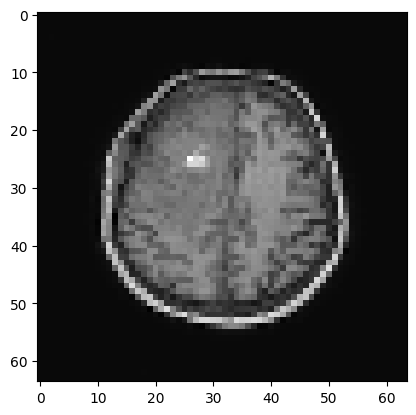

(8, 64, 64)
Plage des valeurs des images d'entrée (bruitées) : 0.0 - 1.000000052762211
torch.Size([8, 64, 64])


In [13]:
# tester avec Pelvis pour un model entrainer avec des cerveau
indices=[102, 30, 135, 79, 6, 150, 109, 145]


data = np.load("images_brain_64.npy")
bigy_test=data[indices]

print(bigy_test.shape)
print("Mean:", bigy_test.mean().item())
print(f"le min et le max {bigy_test.min()} -{bigy_test.max()}")
print(bigy_test[4,32,:],)
# Affichage d’une image
plt.imshow(bigy_test[4,:,:], cmap="gray")
plt.show()

images_test_normalized = list(bigy_test)

bigy_test = np.stack(images_test_normalized) #Empiler un tableau nunpy
print(bigy_test.shape)
print(f"Plage des valeurs des images d'entrée (bruitées) : {bigy_test.min()} - {bigy_test.max()}")

images_test_normalized_propre=np.array(images_test_normalized)
tensor_images_test_normalized_propre= torch.from_numpy(images_test_normalized_propre)
print(tensor_images_test_normalized_propre.shape)
#tensor_images_test_normalized_propre = tensor_images_test_normalized_propre.unsqueeze(1)




F_shifted.shape: torch.Size([8, 64, 64, 2])
Plage des valeurs des images d'entrée (bruitées) : 0.0 - 1.0
<class 'torch.Tensor'>
F_shifted.shape: torch.Size([8, 64, 64, 2])
Plage des valeurs des images d'entrée (bruitées) : -0.012452845574385462 - 0.03420743016751416


Text(0.5, 1.0, 'tensor_images_test_normalized_propre ')

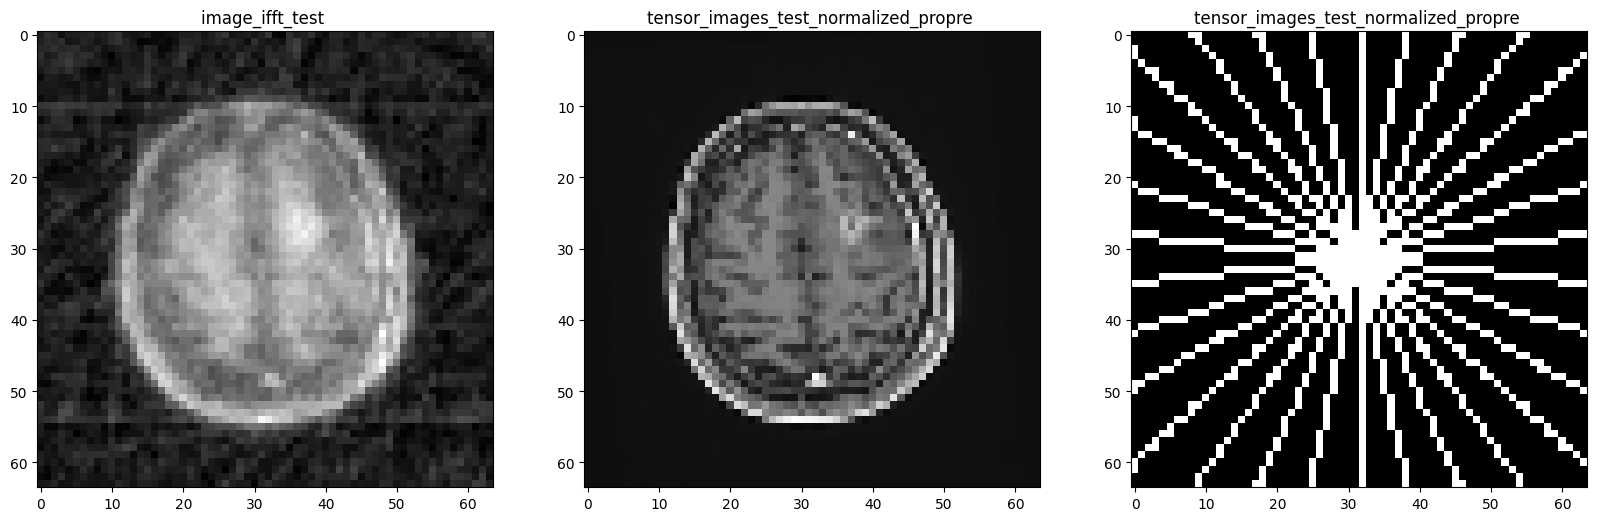

In [15]:
#Modele

import random

F_shifted_mask_test_images = []  # Liste pour stocker les F_shifted de chaque image
F_shifted_mask_test_with_images = [] 

rotation = 12

for image in(images_test_normalized):

    rot=0
    
    FT1_test = fft2(image)
    total_energy = np.sum(np.abs(FT1_test))
    FT1_test = FT1_test / (total_energy + 1e-8)
    F_shifted_test = fftshift(FT1_test)

    rows, cols = F_shifted_test.shape
    crow, ccol = rows // 2, cols // 2

    # Créer un masque directionnel
    #mask1 = np.ones((rows, cols), dtype=np.float32) # Pas de masque car que des 1
    mask0_test = np.zeros((rows, cols), dtype=np.float32)
    for angle_deg in np.arange(0, 180, rotation):  
        angle_rad = np.deg2rad(angle_deg)
        dx = np.cos(angle_rad)
        dy = np.sin(angle_rad)

        for r in range(-max(rows, cols), max(rows, cols)):
            x = int(crow + r * dx)
            y = int(ccol + r * dy)
            
            if 0 <= x < rows and 0 <= y < cols:
                mask0_test[x, y] = 1

    mask1_test = np.zeros((rows, cols), dtype=np.float32)
    for x in range(0,rows,1):
        if (crow - 5 < x < crow + 5):
            mask1_test[x, :] = 1
        elif (crow - 13 < x < crow - 10):
            mask1_test[x, :] = 1
        elif (crow + 10 < x < crow + 13):
            mask1_test[x, :] = 1    
        elif (crow + 20 < x < crow + 22):
            mask1_test[x, :] = 1    
        elif (crow - 23 < x < crow - 20):
            mask1_test[x, :] = 1
        # if (crow - 7 < x < crow + 7):
        #     mask1_test[x, :] = 1
        # elif (crow - 15 < x < crow - 10):
        #     mask1_test[x, :] = 1
        # elif (crow + 10 < x < crow + 15):
        #     mask1_test[x, :] = 1    
        # elif (crow + 20 < x < crow + 25):
        #     mask1_test[x, :] = 1    
        # elif (crow - 25 < x < crow - 20):
        #     mask1_test[x, :] = 1
        # elif (crow + 30 < x < crow + 33):
        #     mask1_test[x, :] = 1    
        # elif (crow - 33 < x < crow - 30):
        #     mask1_test[x, :] = 1
        # if (crow - 15 < x < crow + 15):
        #     mask1_test[x, :] = 1   
        # elif (crow + 18 < x < crow + 25):
        #     mask1_test[x, :] = 1    
        # elif (crow - 25 < x < crow - 18):
        #     mask1_test[x, :] = 1
        # elif (crow + 30 < x < crow + 35):
        #     mask1_test[x, :] = 1    
        # elif (crow - 35 < x < crow - 30):
        #     mask1_test[x, :] = 1
        # elif (crow + 40 < x < crow + 45):
        #     mask1_test[x, :] = 1    
        # elif (crow - 45 < x < crow - 40):
        #     mask1_test[x, :] = 1
        

        

    # Appliquer le masque avec K_space
    F_shifted_mask_test=mask0_test #* F_shifted 
    F_shifted_mask1_test=F_shifted_test * mask0_test
    #Partie réel et imaginaire
    #real_part = np.real(F_shifted_mask)
    #imag_part = np.imag(F_shifted_mask)
    real_part_test = F_shifted_mask_test
    imag_part_test = F_shifted_mask_test

    real_part1_test = np.real(F_shifted_mask1_test)
    imag_part1_test = np.imag(F_shifted_mask1_test)
    F_masked_complex_test = np.stack((real_part_test, imag_part_test), axis=-1)
    F_masked_complex1_test = np.stack((real_part1_test, imag_part1_test), axis=-1)
    # magnitude_spectrum = np.abs(F_shifted_mask)
    F_shifted_mask_test_images.append(F_masked_complex_test)
    F_shifted_mask_test_with_images.append(F_masked_complex1_test)



# MASQUE 2 CANAUX réel et phase
F_mask_test= np.array(F_shifted_mask_test_images)
#F_mask_test = np.transpose(F_mask_test, (0, 3, 1, 2))
tensor_F_mask_test = torch.from_numpy(F_mask_test)
print(f"F_shifted.shape: {tensor_F_mask_test.shape}") 
print(f"Plage des valeurs des images d'entrée (bruitées) : {tensor_F_mask_test.min()} - {tensor_F_mask_test.max()}")


F_mask_test_image= np.array(F_shifted_mask_test_with_images)
#F_mask_test_image = np.transpose(F_mask_test_image, (0, 3, 1, 2))
tensor_F_mask_test_image = torch.from_numpy(F_mask_test_image)
print(type(tensor_F_mask_test_image))
print(f"F_shifted.shape: {tensor_F_mask_test_image.shape}") 
print(f"Plage des valeurs des images d'entrée (bruitées) : {tensor_F_mask_test_image.min()} - {tensor_F_mask_test_image.max()}")


real1_test=tensor_F_mask_test_image[0,:,:,0]
imag1_test=tensor_F_mask_test_image[0,:,:,1]
image_ifft_test=torch.abs(torch.fft.ifft2(torch.fft.ifftshift(real1_test + imag1_test*1j)))

plt.figure(figsize=(20,8))
plt.subplot(1, 3, 1)
plt.imshow(image_ifft_test, cmap="gray")
plt.title("image_ifft_test ")
plt.subplot(1, 3, 2)
plt.imshow(tensor_images_test_normalized_propre[0,:,:], cmap="gray")
plt.title("tensor_images_test_normalized_propre ")
plt.subplot(1, 3, 3)
plt.imshow(tensor_F_mask_test[0,:,:,0], cmap="gray")
plt.title("tensor_images_test_normalized_propre ")

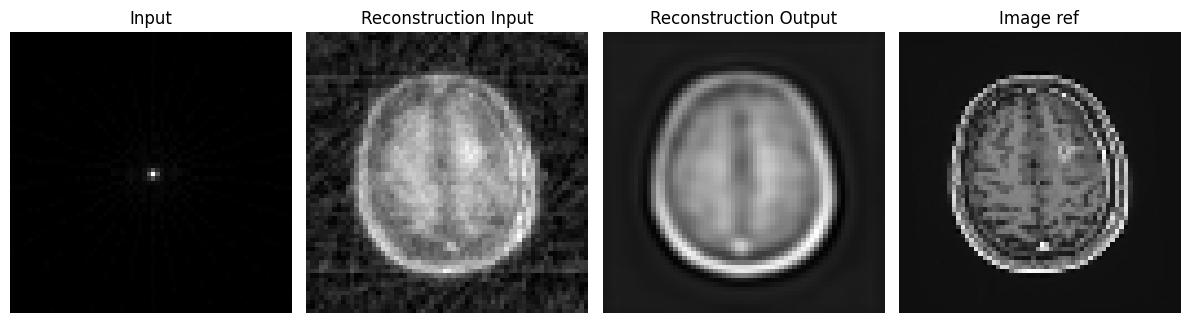

 ifft -> 15.92 dB
 modèle -> 19.72 dB
 ifft -> 15.22 dB
 modèle -> 18.23 dB
 ifft -> 15.92 dB
 modèle -> 21.65 dB
 ifft -> 19.02 dB
 modèle -> 19.41 dB
 ifft -> 17.46 dB
 modèle -> 21.32 dB
 ifft -> 15.94 dB
 modèle -> 20.82 dB
 ifft -> 16.38 dB
 modèle -> 20.00 dB
 ifft -> 16.72 dB
 modèle -> 18.33 dB
PSNR
 Entrée -> 16.57 dB
 Sortie -> 19.93 dB
 ecart-type Entrée -> 1.19 dB
 ecart-type Sortie -> 1.28 dB


In [16]:
#from skimage.metrics import structural_similarity as ssim
#import piq

# 1. Recréer le modèle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Automap().to(device)

moyenne_PSNR_seed_entre=[]
moyenne_PSNR_seed_sortie=[]
moyenne_ecart_type_seed_entre=[]
moyenne_ecart_type_seed_sortie=[]

# 2. Charger les poids
#for seed in dict_seed:
path_model = path_folder + f"/Automap_image_brain_radial_64_rotation0125.pth"
model.load_state_dict(torch.load(path_model, map_location=torch.device('cpu')))
model.eval()

input_imgs_liste=[]
target_imgs_liste=[]

with torch.no_grad(): #Désactive les gradients car pas de back propagation 
    # for input_imgs,target_imgs in test_loader:
    # ##input_imgs, target_imgs = next(iter(dict_seed[seed]["test"])) # 16 premières images pour mon batchsize
    #     input_imgs = input_imgs.to(device).float()
    #     target_imgs = target_imgs.to(device).float()
    #     input_imgs_liste.append(input_imgs)
    #     target_imgs_liste.append(target_imgs)
    

    # input_imgs = torch.cat(input_imgs_liste, dim=0)
    # target_imgs = torch.cat(target_imgs_liste, dim=0)

    input_imgs = tensor_F_mask_test_image.to(device).float()
    target_imgs = tensor_images_test_normalized_propre.to(device).float()

    reconstructed = model(input_imgs)

    index=input_imgs.shape[0]
    #print(index)

    i = 0
    
    #print("input_imgs[i] shape:", input_imgs[i].shape)
    fig, axs = plt.subplots(1, 4, figsize=(12, 4))
    #print(input_imgs[i].shape)
    real1=input_imgs[i,:,:,0]
    imag1=input_imgs[i,:,:,1]

    complex_kspace = real1 + 1j * imag1
    #print("complex_kspace", complex_kspace.shape, complex_kspace.dtype)

    image_ifft = torch.abs(torch.fft.ifft2(torch.fft.ifftshift(real1 + imag1*1j)))
    #print('ifft',image_ifft.shape)
    
    amplitude = torch.sqrt(real1**2 + imag1**2)
    #magnitude_spectrum=torch.log(amplitude + 1)

    #print(type( amplitude))
    axs[0].imshow(amplitude.squeeze().cpu(), cmap='gray')
    axs[0].set_title(f"Input" )
    axs[1].imshow(image_ifft.squeeze().cpu(), cmap='gray')
    axs[1].set_title(f"Reconstruction Input")
    axs[2].imshow(reconstructed[i].squeeze().cpu(), cmap='gray')
    axs[2].set_title(f"Reconstruction Output")
    axs[3].imshow(target_imgs[i].squeeze().cpu(), cmap='gray')
    axs[3].set_title(f"Image ref")


    test_ifft = (image_ifft- torch.min(image_ifft))/(torch.max(image_ifft)-torch.min(image_ifft))
    #print('ifft',image_ifft.shape)
    #print('target',target_imgs[i].shape)
    
    mse1 = torch.mean((test_ifft - target_imgs[i]) ** 2)
    psnr_value1 = 10 * torch.log10(1.0**2 / mse1)
    #print(f" PSNR sur l'image d'entrée : {psnr_value1:.2f} dB")   

    # Calculer la MSE (Mean Squared Error)
    mse2 = torch.mean((reconstructed[i] - target_imgs[i])** 2)
    psnr_value2 = 10 * torch.log10(1.0**2 / mse2)
    #print(f" PSNR sur l'image de sortie du modèle: {psnr_value2:.2f} dB")
    
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


    psnr_somme1=0
    psnr_somme2=0

    liste_psnr_values1 = []
    #image reconstruite
    liste_psnr_values2 = []

    for i in range (index):
        real = input_imgs[i, :, :, 0]
        imag = input_imgs[i, :, :, 1]
        complex_kspace = real + 1j * imag

        # Reconstruction par ifft
        image_ifft = torch.abs(torch.fft.ifft2(torch.fft.ifftshift(complex_kspace)))
        # Normalisation individuelle
        test1_ifft = (image_ifft - torch.min(image_ifft)) / (torch.max(image_ifft) - torch.min(image_ifft))

        
        mse1 = torch.mean((test1_ifft - target_imgs[i]) ** 2)
        psnr_value1 = 10 * torch.log10(1.0 **2/ mse1)
        liste_psnr_values1.append(psnr_value1)
        print(f" ifft -> {psnr_value1:.2f} dB")   
        
        # Calculer la MSE/PSNR (Mean Squared Error)
        mse2 = torch.mean((target_imgs[i] - reconstructed[i])** 2)
        psnr_value2 = 10 * torch.log10(1.0**2 / mse2)
        liste_psnr_values2.append(psnr_value2)
        print(f" modèle -> {psnr_value2:.2f} dB")    
        
    # Conversion en tenseur pour calculs statistiques
    psnr_values_input = torch.tensor(liste_psnr_values1)
    psnr_values_output = torch.tensor(liste_psnr_values2)

    #Moyenne PSNR
    PNSR_entre=torch.mean(psnr_values_input)
    PSNR_sortie=torch.mean(psnr_values_output)

    #Ecart_type PSNR
    ecart_type_entre=torch.std(psnr_values_input)
    ecart_type_sortie=torch.std(psnr_values_output)

    print("PSNR")  
    print(f" Entrée -> {PNSR_entre:.2f} dB")    
    moyenne_PSNR_seed_entre.append(PNSR_entre)   
    print(f" Sortie -> {PSNR_sortie:.2f} dB") 
    moyenne_PSNR_seed_sortie.append(PSNR_sortie)   
    print(f" ecart-type Entrée -> {ecart_type_entre:.2f} dB") 
    moyenne_ecart_type_seed_entre.append(ecart_type_entre)     
    print(f" ecart-type Sortie -> {ecart_type_sortie:.2f} dB")
    moyenne_ecart_type_seed_sortie.append(ecart_type_sortie)  







    

In [25]:
# Entree
moyenne_PSNR_entree=0
for m in moyenne_PSNR_seed_entre:
    moyenne_PSNR_entree+=m
    
print(f"Moyenne_PSNR_entree: {moyenne_PSNR_entree/5}")
F_moyenne_PSNR_seed_entree=torch.tensor(moyenne_PSNR_seed_entre)
ecart_type_entre_PSNR_entree=torch.std(F_moyenne_PSNR_seed_entree)
print(f"Ecart-type: {ecart_type_entre_PSNR_entree}")

# Sortie
moyenne_PSNR_sortie=0
for m in moyenne_PSNR_seed_sortie:
    #print(m)
    moyenne_PSNR_sortie+=m
    
print(f"Moyenne_PSNR_sortie: {moyenne_PSNR_sortie/5}")
F_moyenne_PSNR_seed_sortie=torch.tensor(moyenne_PSNR_seed_sortie)
ecart_type_entre_PSNR_sortie=torch.std(F_moyenne_PSNR_seed_sortie)
print(f"Ecart-type: {ecart_type_entre_PSNR_sortie}")

Moyenne_PSNR_entree: 3.9843051433563232
Ecart-type: nan
Moyenne_PSNR_sortie: 3.0625007152557373
Ecart-type: nan


C:\Users\rapha\AppData\Local\Temp\ipykernel_3788\1073275032.py:8: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  ecart_type_entre_PSNR_entree=torch.std(F_moyenne_PSNR_seed_entree)
C:\Users\rapha\AppData\Local\Temp\ipykernel_3788\1073275032.py:19: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  ecart_type_entre_PSNR_sortie=torch.std(F_moyenne_PSNR_seed_sortie)
